# XGBoost Algorithm Demonstration 

### Dataset used - Airlines Delay

Airline on-time statistics and delay causes

<b>Aim : To determine/predict whether a flight will be delayed based on data provided.</b>

In [1]:
import dask
from dask.distributed import Client, progress, LocalCluster
client = Client(n_workers=1)
client.restart()
client
# <Client: scheduler='tcp://172.31.33.0:8786' processes=10 cores=80>

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 7.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62380,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.83 GiB
Comm: tcp://127.0.0.1:62401,Total threads: 8
Dashboard: http://127.0.0.1:62402/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:62383,


## XGBoost Implementation on Airline Data (using Dask)

#### Load the Data

In [2]:
%%time


import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'Distance',
        'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
df = dd.read_csv('DelayedFlights.csv', usecols=cols,
                  storage_options={'anon': True})

df = df.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster



df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)




Wall time: 1.17 s


##### Remove Missing Values

In [3]:
df = df.dropna()

In [4]:
df.head()

,Year,Month,DayOfWeek,CRSDepTime,UniqueCarrier,DepDelay,Origin,Dest,Distance
184789,2008,2,7,1910,WN,181.0,SEA,SLC,689
225785,2008,2,5,520,XE,7.0,MSP,IAH,1034
21995,2008,1,4,1715,WN,56.0,LAS,PHX,256
72312,2008,1,2,2015,UA,170.0,ORD,MSY,837
554362,2008,3,4,2155,B6,175.0,PBI,JFK,1028


##### Dependent Column is DepDelay

In [5]:
is_delayed = (df.DepDelay.fillna(16) > 15)  # column of labels

# Remove delay information from training dataframe
del df['DepDelay']  

In [6]:
df, is_delayed = dask.persist(df, is_delayed)  # start work in the background

In [7]:
is_delayed.head()

184789     True
225785    False
21995      True
72312      True
554362     True
Name: DepDelay, dtype: bool

#### Categorize and One Hot Encode

##### XGBoost doesn't want to work with text data like destination="LAX". Instead we create new indicator columns for each of the known airports and carriers. This expands our data into many boolean columns. 

In [8]:
df2 = dd.get_dummies(df.categorize()).persist()

In [9]:
df2

,Year,Month,DayOfWeek,CRSDepTime,Distance,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_UA,UniqueCarrier_B6,UniqueCarrier_OO,UniqueCarrier_YV,UniqueCarrier_NW,UniqueCarrier_CO,UniqueCarrier_OH,UniqueCarrier_AA,UniqueCarrier_DL,UniqueCarrier_AS,UniqueCarrier_US,UniqueCarrier_EV,UniqueCarrier_MQ,UniqueCarrier_9E,UniqueCarrier_FL,UniqueCarrier_F9,UniqueCarrier_AQ,UniqueCarrier_HA,Origin_SEA,Origin_MSP,Origin_LAS,Origin_ORD,Origin_PBI,Origin_SFO,Origin_CLT,Origin_PHL,Origin_IND,Origin_SJC,Origin_MDW,Origin_DFW,Origin_BNA,Origin_DEN,Origin_JFK,Origin_IAH,Origin_CVG,Origin_ATL,Origin_ONT,Origin_OAK,Origin_SAT,Origin_MIA,Origin_BUR,Origin_BDL,Origin_SLC,Origin_ELP,Origin_BWI,Origin_MCO,Origin_SYR,Origin_FAT,Origin_FAR,Origin_LAX,Origin_DTW,Origin_PIT,Origin_AUS,Origin_IAD,Origin_ASE,Origin_FLL,Origin_RSW,Origin_TPA,Origin_FSD,Origin_MKE,Origin_RNO,Origin_LAN,Origin_PHX,Origin_LGA,Origin_DAL,Origin_RDU,Origin_PMD,Origin_ANC,Origin_BOS,Origin_DCA,Origin_EWR,Origin_SAN,Origin_GNV,Origin_OME,Origin_LEX,Origin_XNA,Origin_HPN,Origin_VPS,Origin_OGG,Origin_OMA,Origin_SUN,Origin_EUG,Origin_TUS,Origin_ABQ,Origin_HOU,Origin_STL,Origin_LGB,Origin_PIA,Origin_SMF,Origin_ICT,Origin_DSM,Origin_PVD,Origin_ITO,Origin_MEM,Origin_MCI,Origin_STT,Origin_FWA,Origin_PDX,Origin_OKC,Origin_BUF,Origin_LRD,Origin_ABY,Origin_MSY,Origin_PNS,Origin_SNA,Origin_SAV,Origin_CEC,Origin_CLE,Origin_GEG,Origin_DAB,Origin_GRB,Origin_ATW,Origin_SHV,Origin_CRP,Origin_BFL,Origin_BMI,Origin_MDT,Origin_JAC,Origin_LIT,Origin_BRW,Origin_GRR,Origin_PSG,Origin_DAY,Origin_DBQ,Origin_LBB,Origin_SDF,Origin_AZO,Origin_SBA,Origin_SGF,Origin_RIC,Origin_JAX,Origin_HNL,Origin_SJU,Origin_MHT,Origin_PSP,Origin_SBP,Origin_TXK,Origin_BHM,Origin_SWF,Origin_MGM,Origin_BOI,Origin_AVL,Origin_ORF,Origin_MLU,Origin_RST,Origin_MSN,Origin_BTR,Origin_MOD,Origin_CMI,Origin_PWM,Origin_DLH,Origin_ALB,Origin_CLL,Origin_CID,Origin_CRW,Origin_CMH,Origin_ACT,Origin_RDD,Origin_MFE,Origin_TVC,Origin_TYS,Origin_CAE,Origin_FLG,Origin_MOT,Origin_MLI,Origin_BIL,Origin_DRO,Origin_AMA,Origin_ERI,Origin_TLH,Origin_FNT,Origin_SMX,Origin_GPT,Origin_YKM,Origin_EGE,Origin_SCC,Origin_BET,Origin_BTV,Origin_HSV,Origin_MFR,Origin_SRQ,Origin_LNK,Origin_TYR,Origin_JAN,Origin_ROA,Origin_FCA,Origin_GSP,Origin_ROC,Origin_ACV,Origin_CWA,Origin_HDN,Origin_CSG,Origin_GSO,Origin_CAK,Origin_PHF,Origin_ELM,Origin_ABE,Origin_LIH,Origin_ABI,Origin_IPL,Origin_GRK,Origin_COS,Origin_RDM,Origin_AVP,Origin_TUL,Origin_IDA,Origin_MRY,Origin_CHS,Origin_MLB,Origin_MAF,Origin_STX,Origin_MOB,Origin_SBN,Origin_TOL,Origin_BZN,Origin_CHA,Origin_MYR,Origin_BRO,Origin_KOA,Origin_MTJ,Origin_FAY,Origin_CIC,Origin_CDC,Origin_HRL,Origin_MBS,Origin_WRG,Origin_SPI,Origin_OTZ,Origin_BGR,Origin_GTF,Origin_ISP,Origin_JNU,Origin_TWF,Origin_LAW,Origin_EVV,Origin_TRI,Origin_GTR,Origin_GJT,Origin_ILM,Origin_SGU,Origin_MSO,Origin_PSE,Origin_LWS,Origin_AEX,Origin_BQK,Origin_SPS,Origin_AGS,Origin_YUM,Origin_ROW,Origin_GGG,Origin_GUC,Origin_CPR,Origin_PFN,Origin_CHO,Origin_RAP,Origin_SJT,Origin_LFT,Origin_SLE,Origin_GFK,Origin_MQT,Origin_EKO,Origin_VLD,Origin_FAI,Origin_YAK,Origin_TEX,Origin_CDV,Origin_PSC,Origin_FSM,Origin_LYH,Origin_CLD,Origin_EYW,Origin_IYK,Origin_KTN,Origin_PIH,Origin_OXR,Origin_RFD,Origin_COD,Origin_LSE,Origin_BIS,Origin_ADQ,Origin_BQN,Origin_SIT,Origin_CMX,Origin_DHN,Origin_MCN,Origin_MKG,Origin_LCH,Origin_FLO,Origin_MEI,Origin_HHH,Origin_HLN,Origin_SCE,Origin_BPT,Origin_EWN,Origin_BGM,Origin_GCC,Origin_SUX,Origin_OAJ,Origin_BTM,Origin_ADK,Origin_PLN,Origin_ACY,Origin_RKS,Origin_ALO,Origin_BLI,Origin_RHI,Origin_GST,Origin_DLG,Origin_ACK,Origin_LWB,Origin_LMT,Origin_AKN,Origin_WYS,Origin_OTH,Origin_ITH,Origin_HTS,Origin_PIR,Dest_SLC,Dest_IAH,Dest_PHX,Dest_MSY,Dest_JFK,Dest_FAT,Dest_BWI,Dest_GEG,Dest_DTW,Dest_LAS,Dest_ABQ,Dest_EWR,Dest_MCI,Dest_DEN,Dest_DRO,Dest_BNA,Dest_SAT,Dest_AUS,Dest_DSM,Dest_MCO,Dest_CLT,Dest_SNA,Dest_ICT,Dest_HOU,Dest_LAX,Dest_IAD,Dest_PVD,Dest_EGE,Dest_GJT,Dest_SFO,Dest_FLL,Dest_BTM,Dest_ATL,Dest_STL,Dest_SDF,Dest_CMH,Dest_

In [10]:
df2.head()

,Year,Month,DayOfWeek,CRSDepTime,Distance,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_UA,UniqueCarrier_B6,UniqueCarrier_OO,...,Dest_LWB,Dest_GST,Dest_DLG,Dest_RHI,Dest_LMT,Dest_OTH,Dest_AKN,Dest_BJI,Dest_HTS,Dest_ITH
184789,2008,2,7,1910,689,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
225785,2008,2,5,520,1034,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21995,2008,1,4,1715,256,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72312,2008,1,2,2015,837,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
554362,2008,3,4,2155,1028,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


No. of Columns

In [11]:
len(df2.columns)

623

##### Split into Training & Testing Data

##### We split our data randomly in a 90%/10% split for training and testing. XGBoost is then setup and data is handed off for training

In [12]:
%%time
data_train, data_test = df2.random_split([0.9, 0.1], random_state=0)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], random_state=0)

print(labels_train)

Dask Series Structure:
npartitions=3
    bool
     ...
     ...
     ...
Name: DepDelay, dtype: bool
Dask Name: split, 9 tasks
Wall time: 136 ms


In [13]:
%%time
import dask_xgboost as dxgb

param = {'objective': 'binary:logistic', 'nround': 1000,
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 1, 'tree_method': 'hist',
          'grow_policy': 'lossguide'}

# param = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,  # the training step for each iteration
#     'objective': 'multi:softprob',  # error evaluation for multiclass training
#     'num_class': 3,
#     # 'silent': 0, 
#     'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
# num_round = 200  # the number of training iterations



bst = dxgb.train(client, param, data_train, labels_train)

Wall time: 46 s


###### Our output is just a normal XGBoost Booster object.

In [14]:
bst

##### Calculating Predictions

In [16]:
# dask-xgboost is used to predict in parallel across the cluster
predictions = dxgb.predict(client, bst, data_test).persist()
predictions

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

## XGBoost Implementation on Airline Data (without Dask)

#### Load the Data

In [17]:
%%time
import numpy as np
import pandas as pd

cols = ['Year', 'Month', 'DayOfWeek', 'Distance',
        'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']


dfpd = pd.read_csv('DelayedFlights.csv', usecols=cols)


dfpd = dfpd.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster

dfpd['CRSDepTime'] = dfpd['CRSDepTime'].clip(upper=2399)




Wall time: 6.79 s


In [18]:
dfpd.head()

,Year,Month,DayOfWeek,CRSDepTime,UniqueCarrier,DepDelay,Origin,Dest,Distance
424857,2008,3,7,1458,YV,87.0,CID,ORD,196
1143088,2008,7,7,1604,OO,6.0,SFO,RNO,192
645965,2008,4,3,1017,US,12.0,PHX,BUR,369
540880,2008,3,6,1835,AA,17.0,MCO,DFW,984
222043,2008,2,3,1450,XE,105.0,EWR,DAY,533


##### Dependent Column is DepDelay

In [19]:
is_delayed_col = (dfpd.DepDelay.fillna(16) > 15)  # column of labels

# Remove delay information from training dataframe
del dfpd['DepDelay']  

In [20]:
is_delayed_col.head()


424857      True
1143088    False
645965     False
540880      True
222043      True
Name: DepDelay, dtype: bool

In [21]:
len(df2.columns)

623

### Using larger dataset. nPartitions = 3 (623 Columns)

#### Importing Libraries

In [22]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import precision_score

#### Split data into Train & Test Sets

In [23]:
data_train, data_test = df2.random_split([0.9, 0.1], random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], random_state=1234)


#### Train XGBoost Model

In [25]:
%%time

# use DMatrix for xgboost
dtrain = xgb.DMatrix(data_train,enable_categorical=True, label=labels_train)
dtest = xgb.DMatrix(data_test,enable_categorical=True, label=labels_test)



# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3,
    'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
num_round = 200  # the number of training iterations



#------------- numpy array ------------------
# training - numpy matrices
bst = xgb.train(param, dtrain, num_round)


Wall time: 18min 5s


#### Calculate Predictions

In [26]:
preds = bst.predict(dtest)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(labels_test, best_preds, average='macro'))



Numpy array precision: 0.6136049026786805


### Using dataset that is non-partitioned. (dfpd - 8 columns)

#### Encode columns into categorical type

In [27]:
dfpd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387352 entries, 424857 to 1882043
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Year           387352 non-null  int64 
 1   Month          387352 non-null  int64 
 2   DayOfWeek      387352 non-null  int64 
 3   CRSDepTime     387352 non-null  int64 
 4   UniqueCarrier  387352 non-null  object
 5   Origin         387352 non-null  object
 6   Dest           387352 non-null  object
 7   Distance       387352 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 26.6+ MB


In [28]:
dfpd['UniqueCarrier'] = dfpd.UniqueCarrier.astype('category')
dfpd['Origin'] = dfpd.Origin.astype('category')
dfpd['Dest'] = dfpd.Dest.astype('category')

In [29]:
dfpd.head()

,Year,Month,DayOfWeek,CRSDepTime,UniqueCarrier,Origin,Dest,Distance
424857,2008,3,7,1458,YV,CID,ORD,196
1143088,2008,7,7,1604,OO,SFO,RNO,192
645965,2008,4,3,1017,US,PHX,BUR,369
540880,2008,3,6,1835,AA,MCO,DFW,984
222043,2008,2,3,1450,XE,EWR,DAY,533


In [30]:
len(dfpd.columns)

8

#### Split data into Train & Test Sets

In [31]:
%%time

# X is training data & Y is test_data
X = dfpd
y = is_delayed_col

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

Wall time: 268 ms


#### Train XGBoost Model

In [32]:
%%time 

# use DMatrix for xgboost
dtrain2 = xgb.DMatrix(X_train,enable_categorical=True, label=y_train)
dtest2 = xgb.DMatrix(X_test,enable_categorical=True, label=y_test)


# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3,
    'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
num_round = 200  # the number of training iterations

# param = {'objective': 'binary:logistic', 'nround': 1000,
#           'max_depth': 3, 'eta': 0.01, 'subsample': 0.5,
#           'min_child_weight': 1, 'tree_method': 'hist',
#           'grow_policy': 'lossguide','eval_metric':'mlogloss'}
# num_round = 2

# training and testing - numpy matrices
bstt = xgb.train(param, dtrain2, num_round)

Wall time: 43.4 s


#### Calculate Predictions

In [33]:
#------------- numpy array ------------------
preds = bstt.predict(dtest2)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))


Numpy array precision: 0.6098652959282183


In [ ]:
#### Evaluate & Plot R

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

import matplotlib

In [36]:
roc_auc = roc_auc_score(y_test, best_preds)

print("ROC AUC Score is: %.2f%%" % (roc_auc*100.0))

ROC AUC Score is: 53.00%


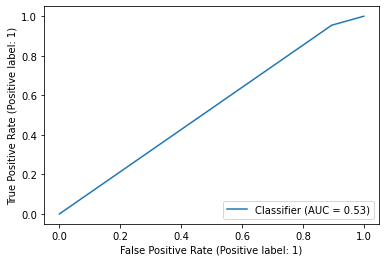

In [37]:
RocCurveDisplay.from_predictions(y_test, best_preds)